<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork817-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Regression-based Rating Score Prediction using Embedding Features**


Estimated time needed: **45** minutes


In our previous lab, you have trained a neural network to predict the user-item interactions while simultaneously extracting the user and item embedding features. In the neural network, extends this by using  two embedding vectors as an input into a Neural Network to predict the rating.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/rating_regression.png)



Another way to make rating predictions is to use the embedding as an input to a neural network by aggregating them into a single feature vector as input data `X`.

With the interaction label `Y` such as a rating score or an enrollment mode, we can build our other standalone predictive models to approximate the mapping from `X` to `Y`, as shown in the above flowchart.


In this lab, you will be given the course interaction feature vectors as input data `X` and consider label `Y` as the numerical rating scores. As such, we turn the recommender system into a common regression task and you can apply what you have learned about regression modeling to predict the ratings.


## Objectives


After completing this lab you will be able to:


* Build regression models to predict ratings using the combined embedding vectors


----


## Prepare and setup lab environment


First install and import required libraries:


In [1]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [2]:
# also set a random state
rs = 123

In [3]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

### Load datasets


In [4]:
rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-ML0321EN-Coursera/labs/v2/module_3/ratings.csv"
user_emb_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/user_embeddings.csv"
item_emb_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_embeddings.csv"

The first dataset is the rating dataset that contains a user-item interaction matrix


In [5]:
rating_df = pd.read_csv(rating_url)

In [6]:
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,5
1,1342067,CL0101EN,3
2,1990814,ML0120ENv3,5
3,380098,BD0211EN,5
4,779563,DS0101EN,3


As you can see from the above data, the user and item are just ids, let's substitute them by their embedding vectors:


In [7]:
# Load user embeddings
user_emb = pd.read_csv(user_emb_url)
# Load item embeddings
item_emb = pd.read_csv(item_emb_url)

In [8]:
user_emb.head()

,user,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,UFeature7,UFeature8,UFeature9,UFeature10,UFeature11,UFeature12,UFeature13,UFeature14,UFeature15
0,1889878,0.080721,-0.129561,0.087998,0.030231,0.082691,-0.004176,-0.003480,0.091464,-0.040247,0.018958,-0.153328,-0.090143,0.082830,-0.058721,0.057929,-0.001472
1,1342067,0.068047,-0.112781,0.045208,-0.007570,-0.038382,0.068037,0.114949,0.104128,-0.034401,0.004011,0.064832,0.165857,-0.004384,0.053257,0.014308,0.056684
2,1990814,0.124623,0.012910,-0.072627,0.049935,0.020158,0.133306,-0.035366,-0.156026,0.039269,0.042195,0.014695,-0.115989,0.031158,0.102021,-0.020601,0.116488
3,380098,-0.034870,0.000715,0.077406,0.070311,-0.043007,-0.035446,0.032846,-0.060944,0.112384,0.002114,0.090660,-0.068545,0.008967,0.063962,0.052347,0.018072
4,779563,0.106414,-0.001887,-0.017211,-0.042277,-0.074953,-0.056732,0.074610,-0.019367,-0.031341,0.064896,-0.048158,-0.047309,-0.007544,0.010474,-0.032287,-0.083983


In [9]:
item_emb.head()

,item,CFeature0,CFeature1,CFeature2,CFeature3,CFeature4,CFeature5,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,CC0101EN,0.009657,-0.005238,-0.004098,0.016303,-0.005274,-0.000361,-0.015081,-0.012229,0.015686,0.008401,-0.035495,0.009381,-0.032560,-0.007292,0.000966,-0.006218
1,CL0101EN,-0.008611,0.028041,0.021899,-0.001465,0.006900,-0.017981,0.010899,-0.037610,-0.019397,-0.025682,-0.000620,0.038803,0.000196,-0.045343,0.012863,0.019429
2,ML0120ENv3,0.027439,-0.027649,-0.007484,-0.059451,0.003972,0.020496,-0.012695,0.036138,0.019965,0.018686,-0.010450,-0.050011,0.013845,-0.044454,-0.001480,-0.007559
3,BD0211EN,0.020163,-0.011972,-0.003714,-0.015548,-0.007540,0.014847,-0.005700,-0.006068,-0.005792,-0.023036,0.015999,-0.023480,0.015469,0.022221,-0.023115,-0.001785
4,DS0101EN,0.006399,0.000492,0.005640,0.009639,-0.005487,-0.000590,-0.010015,-0.001514,-0.017598,0.003590,0.016799,0.002732,0.005162,0.015031,-0.000877,-0.021283


In [10]:
# Merge user embedding features
user_emb_merged = pd.merge(rating_df, user_emb, how='left', left_on='user', right_on='user').fillna(0)
# Merge course embedding features
merged_df = pd.merge(user_emb_merged, item_emb, how='left', left_on='item', right_on='item').fillna(0)

In [11]:
merged_df.head()

,user,item,rating,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,...,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,1889878,CC0101EN,5,0.080721,-0.129561,0.087998,0.030231,0.082691,-0.004176,-0.003480,...,-0.015081,-0.012229,0.015686,0.008401,-0.035495,0.009381,-0.032560,-0.007292,0.000966,-0.006218
1,1342067,CL0101EN,3,0.068047,-0.112781,0.045208,-0.007570,-0.038382,0.068037,0.114949,...,0.010899,-0.037610,-0.019397,-0.025682,-0.000620,0.038803,0.000196,-0.045343,0.012863,0.019429
2,1990814,ML0120ENv3,5,0.124623,0.012910,-0.072627,0.049935,0.020158,0.133306,-0.035366,...,-0.012695,0.036138,0.019965,0.018686,-0.010450,-0.050011,0.013845,-0.044454,-0.001480,-0.007559
3,380098,BD0211EN,5,-0.034870,0.000715,0.077406,0.070311,-0.043007,-0.035446,0.032846,...,-0.005700,-0.006068,-0.005792,-0.023036,0.015999,-0.023480,0.015469,0.022221,-0.023115,-0.001785
4,779563,DS0101EN,3,0.106414,-0.001887,-0.017211,-0.042277,-0.074953,-0.056732,0.074610,...,-0.010015,-0.001514,-0.017598,0.003590,0.016799,0.002732,0.005162,0.015031,-0.000877,-0.021283


Next, we can combine the user features (the column labels starting with `UFeature` and item features (the column labels starting with `CFeature`. In machine learning, there are many ways to aggregate two feature vectors such as element-wise add, multiply, max/min, average, etc. Here we simply add the two sets of feature columns:


In [12]:
# Define column names for user and course embedding features
u_features = [f"UFeature{i}" for i in range(16)] # Assuming there are 16 user embedding features
c_features = [f"CFeature{i}" for i in range(16)]  # Assuming there are 16 course embedding features

# Extract user embedding features
user_embeddings = merged_df[u_features]
# Extract course embedding features
course_embeddings = merged_df[c_features]
# Extract ratings
ratings = merged_df['rating']

# Aggregate the two feature columns using element-wise add
regression_dataset = user_embeddings + course_embeddings.values
# Rename the columns of the resulting DataFrame
regression_dataset.columns = [f"Feature{i}" for i in range(16)]# Assuming there are 16 features
# Add the 'rating' column from the original DataFrame to the regression dataset
regression_dataset['rating'] = ratings
# Display the first few rows of the regression dataset
regression_dataset.head()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Feature15,rating
0,0.090378,-0.134799,0.083900,0.046534,0.077417,-0.004537,-0.018561,0.079236,-0.024561,0.027359,-0.188823,-0.080762,0.050271,-0.066013,0.058894,-0.007689,5
1,0.059437,-0.084740,0.067107,-0.009036,-0.031482,0.050057,0.125847,0.066517,-0.053798,-0.021671,0.064212,0.204660,-0.004188,0.007914,0.027170,0.076114,3
2,0.152061,-0.014739,-0.080112,-0.009516,0.024130,0.153802,-0.048061,-0.119888,0.059234,0.060882,0.004244,-0.166000,0.045002,0.057566,-0.022081,0.108929,5
3,-0.014707,-0.011257,0.073692,0.054763,-0.050547,-0.020599,0.027146,-0.067012,0.106593,-0.020921,0.106658,-0.092025,0.024436,0.086183,0.029232,0.016287,5
4,0.112812,-0.001395,-0.011572,-0.032638,-0.080440,-0.057321,0.064595,-0.020880,-0.048939,0.068486,-0.031359,-0.044577,-0.002381,0.025505,-0.033164,-0.105266,3


By now, we have built the input dataset `X` and the output vector `y`:


In [13]:
X = regression_dataset.iloc[:, :-1]
y = regression_dataset.iloc[:, -1]
print(f"Input data shape: {X.shape}, Output data shape: {y.shape}")

Input data shape: (233306, 16), Output data shape: (233306,)


## TASK: Perform regression on the interaction dataset


Now our input data `X` and output `y` are ready, let's build regression models to map X to y and predict ratings.


y.unique()


You may use `sklearn` to train and evaluate various regression models.


_TODO: First split dataset into training and testing datasets_


In [14]:
### WRITE YOUR CODE HERE
from sklearn.model_selection import train_test_split

# TODO: First split dataset into training and testing datasets
# Using a 70/30 split ratio as planned in our technical slides
# We set a random_state to ensure the results are reproducible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (163314, 16), (163314,)
Testing set shape: (69992, 16), (69992,)


<details>
    <summary>Click here for Hints</summary>
    
Use `train_test_split()` to split dataset into training and testing datasets.  Use `X, y` as input dataset and output vector. Don't forget to specify `random_state = rs` and `test_size=0.3`.


_TODO: Create a basic linear regression model_


In [15]:
### WRITE YOUR CODE HERE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# TODO: First split dataset into training and testing datasets
# Using a 70/30 split ratio as planned in our technical slides
# We set a random_state to ensure the results are reproducible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

# TODO: Create a basic linear regression model
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the model using the training data
lr_model.fit(X_train, y_train)

# Predict the course ratings for the test set
lr_preds = lr_model.predict(X_test)

# Calculate and print the Root Mean Squared Error (RMSE)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
print(f"Basic Linear Regression RMSE: {lr_rmse:.4f}")

Training set shape: (163314, 16), (163314,)
Testing set shape: (69992, 16), (69992,)
Basic Linear Regression RMSE: 0.8174


<details>
    <summary>Click here for Hints</summary>
    
You can call `linear_regression = LinearRegression()` method to create a Linear Regression object


_TODO: Try different regression models such as Ridge, Lasso, ElasticNet and tune their hyperparameters to see which one has the best performance_


In [16]:
### WRITE YOUR CODE HERE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# TODO: First split dataset into training and testing datasets
# Using a 70/30 split ratio as planned in our technical slides
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}\n")

# TODO: Try different regression models and tune their hyperparameters
# We define a dictionary of models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Ridge (alpha=0.1)": Ridge(alpha=0.1),
    "Ridge (alpha=1.0)": Ridge(alpha=1.0),
    "Lasso (alpha=0.01)": Lasso(alpha=0.01),
    "Lasso (alpha=0.1)": Lasso(alpha=0.1),
    "ElasticNet (alpha=0.1, l1_ratio=0.5)": ElasticNet(alpha=0.1, l1_ratio=0.5)
}

results = []

print("Evaluating models...")
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict and calculate RMSE
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    results.append({"Model": name, "RMSE": rmse})
    print(f"{name} RMSE: {rmse:.4f}")

# Convert results to a DataFrame for easy sorting
results_df = pd.DataFrame(results)

# TODO: Pick the minimum RMSE model
best_model_row = results_df.loc[results_df['RMSE'].idxmin()]

print("\n" + "="*30)
print(f"BEST MODEL: {best_model_row['Model']}")
print(f"MINIMUM RMSE: {best_model_row['RMSE']:.4f}")
print("="*30)

Training set shape: (163314, 16), (163314,)
Testing set shape: (69992, 16), (69992,)

Evaluating models...
Linear Regression RMSE: 0.8174
Ridge (alpha=0.1) RMSE: 0.8174
Ridge (alpha=1.0) RMSE: 0.8174
Lasso (alpha=0.01) RMSE: 0.8173
Lasso (alpha=0.1) RMSE: 0.8173
ElasticNet (alpha=0.1, l1_ratio=0.5) RMSE: 0.8173

BEST MODEL: Lasso (alpha=0.01)
MINIMUM RMSE: 0.8173


In [21]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# 1. Train the best model identified (Lasso alpha=0.01)
best_lasso = Lasso(alpha=0.01)
best_lasso.fit(X_train, y_train)

# 2. Generate predictions on the test set
preds = best_lasso.predict(X_test)

# 3. Calculate and print the final RMSE
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"Lasso (alpha=0.01) RMSE: {rmse:.4f}")

# 4. Show sample predictions for the Appendix
# Note: Ensure 'merged_df' is the name of your original source dataframe
print("\nSample Regression Predictions for Appendix:")
results_preview = pd.DataFrame({
    'user': merged_df.loc[y_test.index, 'user'],
    'item': merged_df.loc[y_test.index, 'item'],
    'rating': y_test.values,
    'prediction': preds.round(4)
})
print(results_preview.head(10))

Lasso (alpha=0.01) RMSE: 0.8173

Sample Regression Predictions for Appendix:
           user      item  rating  prediction
173735  1232762  DS0103EN       3      3.9996
20280   1340444  CO0101EN       3      3.9996
201508  1310442  BD0211EN       3      3.9996
170108  1141000  BD0212EN       5      3.9996
187957  1802923  DS0101EN       4      3.9996
24235    435270  RP0151EN       5      3.9996
97215   1592207  SC0103EN       4      3.9996
215994  1452915  CP0101EN       4      3.9996
220019  1827156  DS0101EN       4      3.9996
111534  1113405  DS0301EN       3      3.9996


### Summary


In this lab, you have built regression models to predict numerical course ratings using the embedding feature vectors extracted from neural networks. In the next lab, we can treat the prediction problem as a classification problem as rating only has two categorical values so classification can be a more natural problem statement.


## Authors


[Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/)


### Other Contributors


/tmp/ipython-input-1308749484.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(x='Model', y='RMSE', data=df, palette=colors)


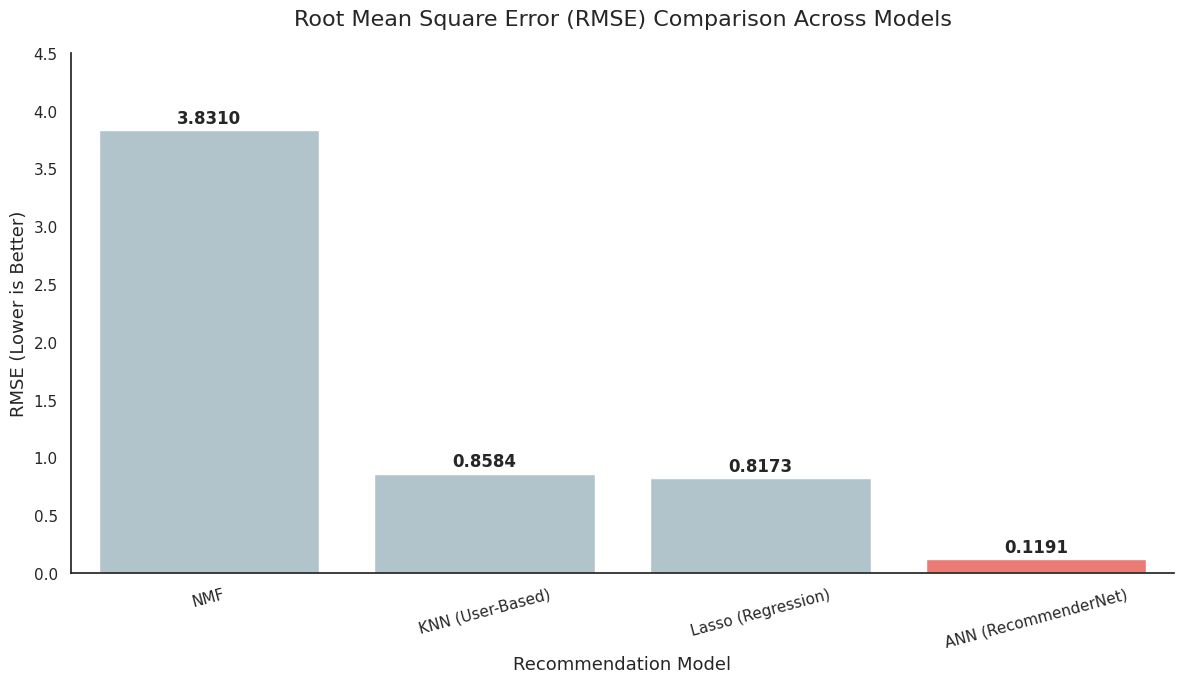

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the data based on your specific results
data = {
    'Model': ['NMF', 'KNN (User-Based)', 'Lasso (Regression)', 'ANN (RecommenderNet)'],
    'RMSE': [3.8310, 0.8584, 0.8173, 0.1191]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Sort the values to make the comparison clearer (lowest RMSE is best)
df = df.sort_values('RMSE', ascending=False)

# Set the visual style to "white" to remove the grid lines
sns.set_theme(style="white")
plt.figure(figsize=(12, 7))

# Create the barplot
# We use a palette to distinguish the models, highlighting the best one (ANN)
colors = ['#aec6cf' if (x > min(df['RMSE'])) else '#ff6961' for x in df['RMSE']]
plot = sns.barplot(x='Model', y='RMSE', data=df, palette=colors)

# Add value labels on top of each bar
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.4f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points',
                   fontsize=12, fontweight='bold')

# Customize the chart labels and title
plt.title('Root Mean Square Error (RMSE) Comparison Across Models', fontsize=16, pad=20)
plt.ylabel('RMSE (Lower is Better)', fontsize=13)
plt.xlabel('Recommendation Model', fontsize=13)
plt.xticks(rotation=15)
plt.ylim(0, 4.5) # Providing some headroom for the labels

# Remove the top and right spines for a cleaner look
sns.despine()

# Clean up layout and show
plt.tight_layout()
plt.show()

```toggle## Change Log
```


```toggle|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
```
```toggle|-|-|-|-|
```
```toggle|2021-10-25|1.0|Yan|Created the initial version|
```


Copyright © 2021 IBM Corporation. All rights reserved.
